In [1]:
import config
import os
import datetime
import random
import pandas as pd
import dask
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

import numpy as np
import math
import geopandas as gpd
from shapely.geometry import Polygon
import scienceplots
import matplotlib.pyplot as plt
plt.style.use(['science'])

DATASET = '/Volumes/WD_BLACK/dataset/chengdu'
N = 1200
M = 600

In [2]:
def unix_to_datetime(timestamp: str) -> datetime:
    """ Convert Unix timestamp to datetime object
    >>> dt = unix_to_datetime('1538402919')
    >>> print(dt.strftime('%Y/%m/%d %H:%M:%S'))
    2018/10/01 22:08:39
    """
    return datetime.datetime.fromtimestamp(int(timestamp))

def gps_to_grid(lat, lon):
    """ Calculate grid index for a given GPS coordinate """
    lat_index = int((lat - (min_lat - delta_lat / 2)) / delta_lat)
    lon_index = int((lon - (min_lon - delta_lon / 2)) / delta_lon)
    return lat_index, lon_index

def grid_to_gps(lat_index, lon_index):
    """ Calculate GPS coordinates of the center point for a given grid index """
    lat = lat_index * delta_lat + min_lat
    lon = lon_index * delta_lon + min_lon
    return lat, lon

def get_filepaths(root_dir=DATASET, prefix='chengdu', suffix='.csv'):
    """ Get filepaths for files in the dataset directory """
    return [os.path.join(root_dir, file) 
            for file in os.listdir(root_dir) 
            if file.startswith(prefix) and file.endswith(suffix)]

def apply_expand(row):
    """ Process each row of the DataFrame """
    wid, oid = row['wid'], row['oid']
    points = row['traj'][1:-1].split(',')
    data = [{'wid': wid, 
             'oid': oid,
             'lon': float(lon), 
             'lat': float(lat),
             'dt': unix_to_datetime(timestamp)}
                for lon, lat, timestamp in (
                    point.strip().split(' ') for point in points
            )]
    return pd.DataFrame(data)

def map_expand(partition):
    """ Process each partition of the DataFrame """
    return pd.concat([apply_expand(row) for index, row in partition.iterrows()]).drop_duplicates()

# Selection

## Workers

In [3]:
filepaths = get_filepaths()
filepaths

['/Volumes/WD_BLACK/dataset/chengdu/chengdushi_1001_1010.csv',
 '/Volumes/WD_BLACK/dataset/chengdu/chengdushi_1010_1020.csv',
 '/Volumes/WD_BLACK/dataset/chengdu/chengdushi_1020_1031.csv',
 '/Volumes/WD_BLACK/dataset/chengdu/chengdushi_1101_1110.csv',
 '/Volumes/WD_BLACK/dataset/chengdu/chengdushi_1110_1120.csv',
 '/Volumes/WD_BLACK/dataset/chengdu/chengdushi_1120_1130.csv']

In [4]:
ddf_origin = dd.read_csv(filepaths, header=None, names=['oid', 'wid', 'traj'])
ddf_origin.head()

,oid,wid,traj
0,92a1d44607c036fbc9db971258c0e013,f5e36c97e4a8052a2aa9c7f8ed0f969a,"[104.04538 30.70745 1538402919, 104.04538 30.7..."
1,0e95f18113ad01cf626289344fd39f4e,c5f1bba8b2cfad357a9ed65dc3021ff1,"[104.08169 30.6705 1538406898, 104.08169 30.67..."
2,7dceae818438b836e3d306296b4ccfbd,0e3f29616d126177f5db9bfb27be21de,"[104.04235 30.69204 1538334938, 104.04268 30.6..."
3,94bba68a63c866769c1c3b37834518fa,c480964f535eede621a1ac4dde7073a6,"[104.04714 30.7263 1538345323, 104.04698 30.72..."
4,8601cc60cfea2fc7f599ebf9b2a4d977,5f3cabc6ff9083e6c79f3f798a9c17e2,"[104.11542 30.65289 1538322576, 104.11574 30.6..."


In [5]:
meta = pd.DataFrame({'wid': pd.Series(dtype='object'),
                     'oid': pd.Series(dtype='object'),
                     'lon': pd.Series(dtype='float64'),
                     'lat': pd.Series(dtype='float64'),
                     'dt': pd.Series(dtype='datetime64[ns]')})

output_expanded = os.path.join(DATASET, 'expanded')
if not os.path.exists(output_expanded) or len(os.listdir(output_expanded)) == 0:
    with ProgressBar():
        ddf_origin.map_partitions(map_expand, meta=meta).to_parquet(output_expanded)
    
ddf_expanded = dd.read_parquet(get_filepaths(output_expanded, 'part', '.parquet'))
ddf_expanded.head()

,wid,oid,lon,lat,dt
0,f5e36c97e4a8052a2aa9c7f8ed0f969a,92a1d44607c036fbc9db971258c0e013,104.04538,30.70745,2018-10-01 22:08:39
1,f5e36c97e4a8052a2aa9c7f8ed0f969a,92a1d44607c036fbc9db971258c0e013,104.04538,30.70744,2018-10-01 22:08:48
2,f5e36c97e4a8052a2aa9c7f8ed0f969a,92a1d44607c036fbc9db971258c0e013,104.04537,30.70745,2018-10-01 22:08:58
3,f5e36c97e4a8052a2aa9c7f8ed0f969a,92a1d44607c036fbc9db971258c0e013,104.04536,30.70743,2018-10-01 22:09:08
4,f5e36c97e4a8052a2aa9c7f8ed0f969a,92a1d44607c036fbc9db971258c0e013,104.04537,30.70740,2018-10-01 22:09:18


In [6]:
output_worker = os.path.join(DATASET, 'wid_peek.csv')

if not os.path.exists(output_worker):
    with ProgressBar():
        ddf_expanded['date'] = ddf_expanded['dt'].dt.date
        ddf_expanded[['wid', 'date']].drop_duplicates().groupby(by='wid')['date'].nunique(
            ).reset_index().to_csv(output_worker, single_file=True, index=False)

wid_peek = pd.read_csv(output_worker).sort_values('date', ascending=False)
workers = wid_peek[wid_peek['date'] >= 55]
workers

,wid,date
17406,1ef1df38dd7d31e99ff717ece7b4eeb5,62
639,0116a1a5502b35083b395e9046889c9e,62
38684,44f417e4ffe571786c4375870963c13f,62
61022,6c58c07eca044e631f26ce4d11030c81,62
12204,15934de901099324fa672fe97580d054,62
...,...,...
629,0111c7f3b9619f7f0e8a05889d0f82c4,55
16110,1c83835276ed4fc3cfc90a5d6ad5ce24,55
117063,d0266fa57bbf6edb937f6f8817af35e3,55
135928,f1fed4549c15a85945bee91829f85289,55


In [7]:
output_selected = os.path.join(DATASET, 'selected')

if not os.path.exists(output_selected) or len(os.listdir(output_selected)) == 0:
    with ProgressBar():
        os.makedirs(output_selected, exist_ok=True)
        ddf_expanded[ddf_expanded['wid'].isin(workers['wid'])].to_parquet(output_selected)

selected_files = get_filepaths(output_selected, 'part', '.parquet')
ddf_selected = dd.read_parquet(selected_files)
ddf_selected.head()

,wid,oid,lon,lat,dt
0,f9183431bc9bc5724e79377a88e3784c,502bb569d51d21dada10fd5f3e657b1c,104.09571,30.66221,2018-09-30 23:54:03
1,f9183431bc9bc5724e79377a88e3784c,502bb569d51d21dada10fd5f3e657b1c,104.09571,30.66221,2018-09-30 23:54:05
2,f9183431bc9bc5724e79377a88e3784c,502bb569d51d21dada10fd5f3e657b1c,104.09571,30.66221,2018-09-30 23:54:08
3,f9183431bc9bc5724e79377a88e3784c,502bb569d51d21dada10fd5f3e657b1c,104.09571,30.66221,2018-09-30 23:54:13
4,f9183431bc9bc5724e79377a88e3784c,502bb569d51d21dada10fd5f3e657b1c,104.09571,30.66221,2018-09-30 23:54:15


## Tasks

(575, 5)


<Axes: >

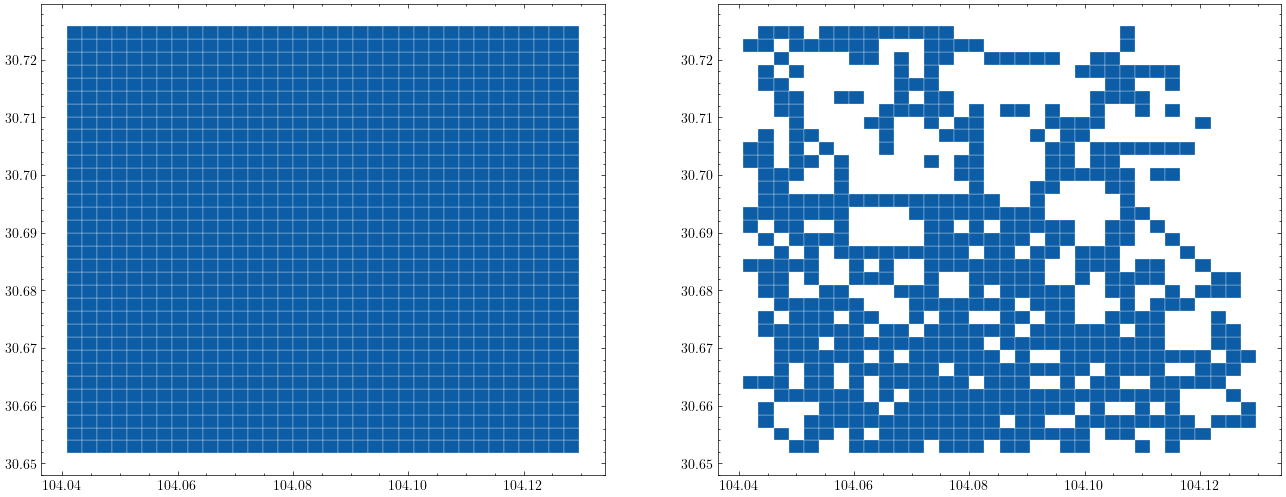

In [55]:
# min_lat, max_lat, min_lon, max_lon = dd.compute(
#     ddf_expanded['lat'].min(),
#     ddf_expanded['lat'].max(),
#     ddf_expanded['lon'].min(),
#     ddf_expanded['lon'].max(),
# )
# min_lat, max_lat, min_lon, max_lon

grid_size = 250
earth_radius = 6371004

min_lat, max_lat, min_lon, max_lon = (30.65283, 30.72649, 104.04211, 104.12907)
delta_lat = grid_size * 360 / (2 * math.pi * earth_radius)
delta_lon = grid_size * 360 / (2 * math.pi * earth_radius * math.cos((min_lat + max_lat) * math.pi / 360))
ddf_selected['lon_index'] = ((ddf_selected['lon'] - (min_lon - delta_lon / 2)) / delta_lon).astype('int')
ddf_selected['lat_index'] = ((ddf_selected['lat'] - (min_lat - delta_lat / 2)) / delta_lat).astype('int')

output_grid = os.path.join(DATASET, 'grid.shp')

# Grids
grid_data_list = []
num_lon_grids = int((max_lon - min_lon) / delta_lon) + 1
num_lat_grids = int((max_lat - min_lat) / delta_lat) + 1
for i in range(num_lon_grids):
    center_lon = i * delta_lon + min_lon
    for j in range(num_lat_grids):
        center_lat = j * delta_lat + min_lat
        grid_polygon = Polygon([
            (center_lon - delta_lon / 2, center_lat - delta_lat / 2),
            (center_lon + delta_lon / 2, center_lat - delta_lat / 2),
            (center_lon + delta_lon / 2, center_lat + delta_lat / 2),
            (center_lon - delta_lon / 2, center_lat + delta_lat / 2)
        ])
        grid_data_list.append({
            'lon_index': i,
            'lat_index': j,
            'lon_center': center_lon,
            'lat_center': center_lat,
            'geometry': grid_polygon
        })
grid_data = gpd.GeoDataFrame(grid_data_list, columns=['lon_index', 'lat_index', 'lon_center', 'lat_center', 'geometry'])
grid_data.set_geometry('geometry', inplace=True)
grid_data.to_file(output_grid)
gdf_grid = gpd.read_file(output_grid)

# Tasks
output_task = os.path.join(DATASET, 'oid_peek.csv')

if not os.path.exists(output_task):
    with ProgressBar():
        oid_peek = ddf_selected[['lon_index', 'lat_index', 'oid']].groupby(by=['lon_index', 'lat_index'])['oid'].count().reset_index().compute()
        oid_peek.sort_values(by='oid', ascending=False).to_csv(output_task, index=False)

oid_peek = pd.read_csv(output_task).sort_values('oid', ascending=False)
tasks = oid_peek[oid_peek['oid'] >= 6e4].copy()
tasks['lat_lon'] = tasks['lat_index'].astype(str) + '-' + tasks['lon_index'].astype(str)


gdf_grid_filtered = gdf_grid.merge(tasks[['lon_index', 'lat_index']], 
                                     on=['lon_index', 'lat_index'], 
                                     how='inner')
print(gdf_grid_filtered.shape)
fig, axes = plt.subplots(1, 2, figsize=(16, 7.5))
gdf_grid.plot(ax=axes[0], edgecolor='white', linewidth=0.2)
gdf_grid_filtered.plot(ax=axes[1], edgecolor='white', linewidth=0.2)

In [9]:
tasks

,lon_index,lat_index,oid,lat_lon
0,15,2,1598446,2-15
1,7,2,1007174,2-7
2,16,1,912002,1-16
3,17,5,892212,5-17
4,11,3,858844,3-11
...,...,...,...,...
574,15,9,60793,9-15
575,25,13,60753,13-25
576,11,18,60700,18-11
577,19,1,60520,1-19


# Attribute

## Data cleaned

In [25]:
output_final = os.path.join(DATASET, 'final')
ddf_selected['lat_lon'] = ddf_selected['lat_index'].astype(str) + '-' + ddf_selected['lon_index'].astype(str)

if not os.path.exists(output_final) or len(os.listdir(output_final)) == 0:
    with ProgressBar():
        os.makedirs(output_final, exist_ok=True)
        ddf_selected[ddf_selected['lat_lon'].isin(tasks['lat_lon'])].to_parquet(output_final)

final_files = get_filepaths(output_final, 'part', '.parquet')
ddf_final = dd.read_parquet(final_files)
ddf_final.head()

,wid,oid,lon,lat,dt,lon_index,lat_index,lat_lon
0,f9183431bc9bc5724e79377a88e3784c,502bb569d51d21dada10fd5f3e657b1c,104.09571,30.66221,2018-09-30 23:54:03,21,4,4-21
1,f9183431bc9bc5724e79377a88e3784c,502bb569d51d21dada10fd5f3e657b1c,104.09571,30.66221,2018-09-30 23:54:05,21,4,4-21
2,f9183431bc9bc5724e79377a88e3784c,502bb569d51d21dada10fd5f3e657b1c,104.09571,30.66221,2018-09-30 23:54:08,21,4,4-21
3,f9183431bc9bc5724e79377a88e3784c,502bb569d51d21dada10fd5f3e657b1c,104.09571,30.66221,2018-09-30 23:54:13,21,4,4-21
4,f9183431bc9bc5724e79377a88e3784c,502bb569d51d21dada10fd5f3e657b1c,104.09571,30.66221,2018-09-30 23:54:15,21,4,4-21


In [26]:
output_grouped_csv = os.path.join(DATASET, 'grouped.csv')
meta = pd.DataFrame({'duration': pd.Series(dtype='float64')})
def calculate_stay_duration(group):
    group = group.sort_values('dt')
    time_diff = group['dt'].diff().dt.total_seconds()
    duration = time_diff[time_diff <= 15].sum()
    return pd.Series({'duration': duration})

if not os.path.exists(output_grouped_csv):
    with ProgressBar():
        grouped = df_final.groupby(['wid', 'lat_lon', 'date'])
        grouped.apply(calculate_stay_duration, meta=meta).reset_index(
            ).to_csv(output_grouped_csv, single_file=True, index=False)

df_grouped = pd.read_csv(output_grouped_csv)
df_grouped.head()

,wid,lat_lon,date,duration
0,0027f0f8779dfc534b78595cd524097e,0-15,2018-10-13,22.0
1,0027f0f8779dfc534b78595cd524097e,0-17,2018-10-03,154.0
2,0027f0f8779dfc534b78595cd524097e,0-3,2018-10-12,74.0
3,0027f0f8779dfc534b78595cd524097e,0-8,2018-11-19,3.0
4,0027f0f8779dfc534b78595cd524097e,1-11,2018-10-24,120.0


In [27]:
df_grouped.describe()

,duration
count,6.778239e+06
mean,4.365061e+01
std,6.477614e+01
min,0.000000e+00
25%,1.200000e+01
50%,2.100000e+01
75%,5.400000e+01
max,4.670200e+04


In [39]:
ddf_final.head()

,wid,oid,lon,lat,dt,lon_index,lat_index,lat_lon
0,f9183431bc9bc5724e79377a88e3784c,502bb569d51d21dada10fd5f3e657b1c,104.09571,30.66221,2018-09-30 23:54:03,21,4,4-21
1,f9183431bc9bc5724e79377a88e3784c,502bb569d51d21dada10fd5f3e657b1c,104.09571,30.66221,2018-09-30 23:54:05,21,4,4-21
2,f9183431bc9bc5724e79377a88e3784c,502bb569d51d21dada10fd5f3e657b1c,104.09571,30.66221,2018-09-30 23:54:08,21,4,4-21
3,f9183431bc9bc5724e79377a88e3784c,502bb569d51d21dada10fd5f3e657b1c,104.09571,30.66221,2018-09-30 23:54:13,21,4,4-21
4,f9183431bc9bc5724e79377a88e3784c,502bb569d51d21dada10fd5f3e657b1c,104.09571,30.66221,2018-09-30 23:54:15,21,4,4-21


In [51]:
with ProgressBar():
    df = ddf_final[ddf_final['wid']=='0027f0f8779dfc534b78595cd524097e'].compute()

[########################################] | 100% Completed | 39.71 s


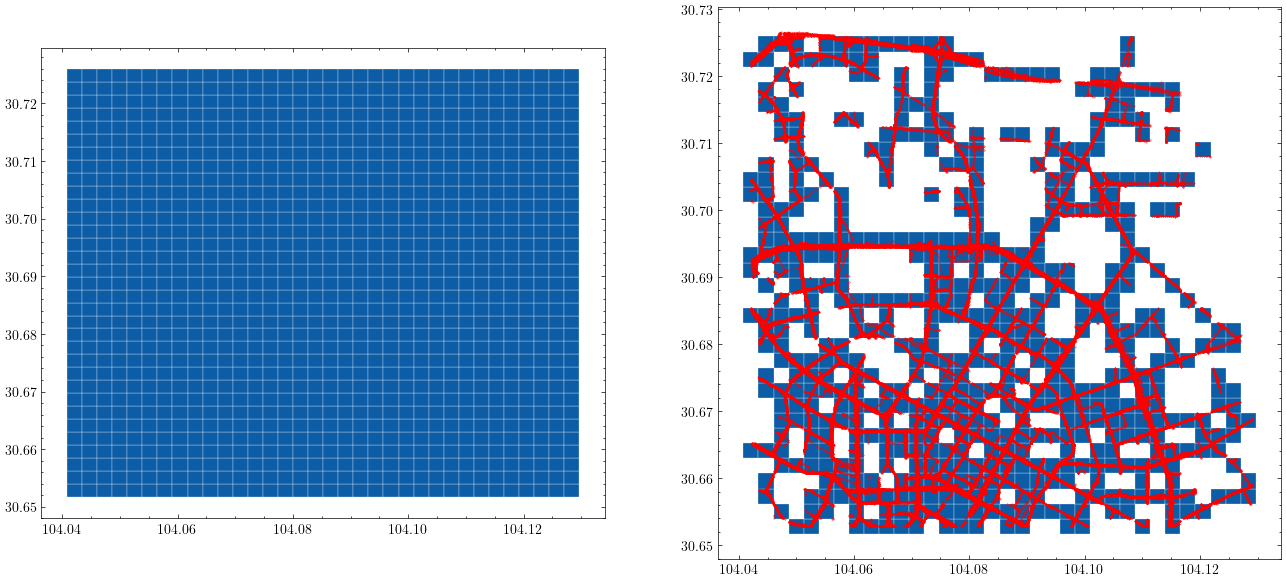

<Figure size 350x262.5 with 0 Axes>

In [56]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['lon'], df['lat']), crs="EPSG:4326")
gdf.plot(ax=axes[1], color="red", markersize=0.1)
fig

In [72]:
# Step 1: Calculate the number of days each driver visits each lat_lon
visits_per_day = df_grouped.groupby(['wid', 'lat_lon'])['date'].nunique().reset_index()
visits_per_day = visits_per_day.rename(columns={'date': 'days_visited'})
visits_per_day

,wid,lat_lon,days_visited
0,0027f0f8779dfc534b78595cd524097e,0-10,17
1,0027f0f8779dfc534b78595cd524097e,0-11,21
2,0027f0f8779dfc534b78595cd524097e,0-13,21
3,0027f0f8779dfc534b78595cd524097e,0-14,9
4,0027f0f8779dfc534b78595cd524097e,0-15,10
...,...,...,...
673287,ffdd7d15f24507c31b0476ea520f68ab,9-4,4
673288,ffdd7d15f24507c31b0476ea520f68ab,9-5,9
673289,ffdd7d15f24507c31b0476ea520f68ab,9-6,10
673290,ffdd7d15f24507c31b0476ea520f68ab,9-7,9


In [71]:
# Step 2: Calculate the number of days with duration limits for each driver at each lat_lon
filtered_df = df_grouped[df_grouped['duration'] > 5]
days_with_long_duration = filtered_df.groupby(['wid', 'lat_lon'])['date'].nunique().reset_index()
days_with_long_duration = days_with_long_duration.rename(columns={'date': 'days_with_long_duration'})
days_with_long_duration

# Step 3: Merge the datasets and calculate the ratio
merged_data = pd.merge(days_with_long_duration, visits_per_day, on=['wid', 'lat_lon'], how='right')
merged_data['duration_ratio'] = 1.0 * merged_data['days_with_long_duration'] / merged_data['days_visited']
merged_data.fillna(0, inplace=True)

merged_data

,wid,lat_lon,days_with_long_duration,days_visited,duration_ratio
0,0027f0f8779dfc534b78595cd524097e,0-10,10.0,17,0.588235
1,0027f0f8779dfc534b78595cd524097e,0-11,18.0,21,0.857143
2,0027f0f8779dfc534b78595cd524097e,0-13,21.0,21,1.000000
3,0027f0f8779dfc534b78595cd524097e,0-14,3.0,9,0.333333
4,0027f0f8779dfc534b78595cd524097e,0-15,10.0,10,1.000000
...,...,...,...,...,...
673287,ffdd7d15f24507c31b0476ea520f68ab,9-4,4.0,4,1.000000
673288,ffdd7d15f24507c31b0476ea520f68ab,9-5,9.0,9,1.000000
673289,ffdd7d15f24507c31b0476ea520f68ab,9-6,10.0,10,1.000000
673290,ffdd7d15f24507c31b0476ea520f68ab,9-7,2.0,9,0.222222


In [73]:
# all_combinations = pd.MultiIndex.from_product([df_grouped['wid'].unique(), df_grouped['lat_lon'].unique()], names=['wid', 'lat_lon']).to_frame(index=False)
arrive_pro = df_grouped[['wid', 'lat_lon', 'date']].groupby(['wid', 'lat_lon']).nunique().reset_index()
arrive_pro['date'] /= 62
# arrive_pro = pd.merge(all_combinations, arrive_pro, on=['wid', 'lat_lon'], how='left').fillna(0)
arrive_pro = arrive_pro.rename(columns={'date': 'ArrivePro'})
arrive_pro

,wid,lat_lon,ArrivePro
0,0027f0f8779dfc534b78595cd524097e,0-10,0.274194
1,0027f0f8779dfc534b78595cd524097e,0-11,0.338710
2,0027f0f8779dfc534b78595cd524097e,0-13,0.338710
3,0027f0f8779dfc534b78595cd524097e,0-14,0.145161
4,0027f0f8779dfc534b78595cd524097e,0-15,0.161290
...,...,...,...
673287,ffdd7d15f24507c31b0476ea520f68ab,9-4,0.064516
673288,ffdd7d15f24507c31b0476ea520f68ab,9-5,0.145161
673289,ffdd7d15f24507c31b0476ea520f68ab,9-6,0.161290
673290,ffdd7d15f24507c31b0476ea520f68ab,9-7,0.145161


In [74]:
combined = pd.merge(arrive_pro, merged_data, on=['wid', 'lat_lon'], how='right')
combined = pd.merge(df_grouped[['wid']].drop_duplicates(ignore_index=True).reset_index(), combined, on=['wid'], how='right')
combined['index'] = combined['index'] + 1
combined.drop(columns=['days_with_long_duration', 'days_visited'], inplace=True)
combined = combined.rename(columns={'duration_ratio':'qPro'})
np.random.seed(0)

combined['lat_lon'] = combined['lat_lon'].apply(lambda s: s.replace(',', '-'))
combined['taskFare'] = np.random.randint(10,25,size=(combined.shape[0], 1))
combined['travelFare'] = np.random.randint(10,25,size=(combined.shape[0], 1))

combined['Fare'] = combined['taskFare'] + combined['travelFare']
combined[['index', 'lat_lon', 'taskFare', 'ArrivePro', 'qPro', 'Fare']].round(
    {'qPro':2, 'ArrivePro':2}).to_csv('everyCarPro.txt', index=False, header=None)

combined = pd.merge(combined.groupby(by=['wid'])['qPro'].mean().reset_index().rename(columns={'qPro':'qPro_avg'}), combined, on=['wid'], how='right')
combined['Pro'] = combined['ArrivePro'] * combined['qPro_avg']

combined[['index', 'qPro_avg']].drop_duplicates().round(
    {'qPro_avg':2}).to_csv('carList.txt', index=False, header=None)

combined[['index', 'qPro_avg']].drop_duplicates().round(
    {'qPro_avg':2}).to_csv('everyCarQualific.txt', index=False, header=None)

combined

,wid,qPro_avg,index,lat_lon,ArrivePro,qPro,taskFare,travelFare,Fare,Pro
0,0027f0f8779dfc534b78595cd524097e,0.91705,1,0-10,0.274194,0.588235,22,15,37,0.251449
1,0027f0f8779dfc534b78595cd524097e,0.91705,1,0-11,0.338710,0.857143,15,11,26,0.310614
2,0027f0f8779dfc534b78595cd524097e,0.91705,1,0-13,0.338710,1.000000,10,13,23,0.310614
3,0027f0f8779dfc534b78595cd524097e,0.91705,1,0-14,0.145161,0.333333,13,19,32,0.133120
4,0027f0f8779dfc534b78595cd524097e,0.91705,1,0-15,0.161290,1.000000,21,12,33,0.147911
...,...,...,...,...,...,...,...,...,...,...
673287,ffdd7d15f24507c31b0476ea520f68ab,0.91130,1196,9-4,0.064516,1.000000,19,22,41,0.058794
673288,ffdd7d15f24507c31b0476ea520f68ab,0.91130,1196,9-5,0.145161,1.000000,11,22,33,0.132285
673289,ffdd7d15f24507c31b0476ea520f68ab,0.91130,1196,9-6,0.161290,1.000000,20,18,38,0.146984
673290,ffdd7d15f24507c31b0476ea520f68ab,0.91130,1196,9-7,0.145161,0.222222,15,18,33,0.132285


In [75]:
output = combined[['index', 'lat_lon', 'taskFare', 'Pro', 'qPro_avg', 'Fare', 'ArrivePro']]
output.round({'Pro':2, 'qPro_avg':2, 'ArrivePro':2,}).to_csv('CarInformation.txt', index=False, header=None)

In [76]:
output['10'] = 10
output[['lat_lon', '10']].to_csv('POI.txt', index=False, header=None)

In [77]:
output

,index,lat_lon,taskFare,Pro,qPro_avg,Fare,ArrivePro,10
0,1,0-10,22,0.251449,0.91705,37,0.274194,10
1,1,0-11,15,0.310614,0.91705,26,0.338710,10
2,1,0-13,10,0.310614,0.91705,23,0.338710,10
3,1,0-14,13,0.133120,0.91705,32,0.145161,10
4,1,0-15,21,0.147911,0.91705,33,0.161290,10
...,...,...,...,...,...,...,...,...
673287,1196,9-4,19,0.058794,0.91130,41,0.064516,10
673288,1196,9-5,11,0.132285,0.91130,33,0.145161,10
673289,1196,9-6,20,0.146984,0.91130,38,0.161290,10
673290,1196,9-7,15,0.132285,0.91130,33,0.145161,10


In [78]:
with open('carList_code', 'w') as fout:
    fout.write(str(output['index'].drop_duplicates().to_list()))